In [1]:
%matplotlib widget

from sklearn.datasets import load_diabetes
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [2]:
diabetes = load_diabetes(scaled=True) # enable Feature Scaling
data = diabetes.data # (m x n) (examples x features)

severity = diabetes.target.reshape((-1,1)) # output of severity of diabetes or disease progression
# mx1

print(data.dtype, severity.dtype) # show datatypes of input and output
print(data.shape) # show shape of input
print(diabetes.feature_names) # show feature names associated with input
print(data)# show data itself

float64 float64
(442, 10)
['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
[[ 0.03807591  0.05068012  0.06169621 ... -0.00259226  0.01990749
  -0.01764613]
 [-0.00188202 -0.04464164 -0.05147406 ... -0.03949338 -0.06833155
  -0.09220405]
 [ 0.08529891  0.05068012  0.04445121 ... -0.00259226  0.00286131
  -0.02593034]
 ...
 [ 0.04170844  0.05068012 -0.01590626 ... -0.01107952 -0.04688253
   0.01549073]
 [-0.04547248 -0.04464164  0.03906215 ...  0.02655962  0.04452873
  -0.02593034]
 [-0.04547248 -0.04464164 -0.0730303  ... -0.03949338 -0.00422151
   0.00306441]]


In [3]:
def predict(w,b,x):
    m = x.shape[0] # number of training examples
    n = x.shape[1] # number of features
    
    prediction = np.matmul(x, w) + b
    return prediction

In [4]:
def mse_cost(w,b,x,y):
    m = x.shape[0] # number of training examples
    n = x.shape[1] # number of features
    
    prediction = np.matmul(x, w) + b
    error = prediction - y
    error = error.reshape((-1)) # make it m (1d array) from mx1
    
    return np.dot(error, error) / (2*m)

In [5]:
def compute_gradient(w,b,x,y):
    m = x.shape[0] # number of training examples
    n = x.shape[1] # number of features

    # w = nx1
    # b = 1
    # x = mxn
    # y = mx1
    
    prediction = np.matmul(x, w) + b # mx1
    error = prediction - y # mx1
    error = error.reshape((1,-1)) # make it 1xm from mx1

    dw = np.matmul(error, x) / m # 1xn
    db = np.sum(error) / m # 1

    dw = dw.reshape((-1,1)) # nx1
    return dw, db

Above is my custom implementation of computing gradients and cost.
I realized i had to reshape a lot of data to make it work with vectorization.
Much of it was reshaping 1d matrices back to vectors. But there is a better way below.

In [6]:
def compute_gradient_better(w,b,x,y):
    m = x.shape[0] # number of training examples
    n = x.shape[1] # number of features

    # w = nx1
    # b = 1
    # x = mxn
    # y = mx1
    
    prediction = np.matmul(x, w) + b # mx1
    error = prediction - y # mx1
    
    xT = np.transpose(x) # nxm
    dw = np.matmul(xT, error) / m # nx1
    db = np.sum(error) / m # 1

    return dw, db

This new gradient code above is from https://towardsdatascience.com/vectorization-implementation-in-machine-learning-ca652920c55d
From this I learned that instead of reshaping matrices, we can transpose them instead and common operations like dot products become matrix multiplications.
This approach is also intuitive as it can be directly translated from math where a reshape is less obvious.

In [7]:
m = data.shape[0] # number of training examples
n = data.shape[1] # number of features

w = np.zeros((n,1)) # n features
b = 0
# initialize model parameters

a=0.3
max_iterations=5000
iteration = np.empty(0, dtype=np.uint)
costs = np.empty(0)

for i in range(max_iterations):
    dw, db = compute_gradient(w,b,data,severity)
    
    w-=a*dw
    b-=a*db
    # update the weights
    
    iteration = np.append(iteration, i)
    current_cost = mse_cost(w,b,data,severity)
    costs = np.append(costs, current_cost)
    # add to array for visualization

Also I tried running gradient descent without feature scaling and the weights basically exploded to huge values and after just a few iterations, gradient descent stopped working. 
These are called exploding gradients.
Eventually, I just re-enabled feature scaling and gradient descent works nicely again.

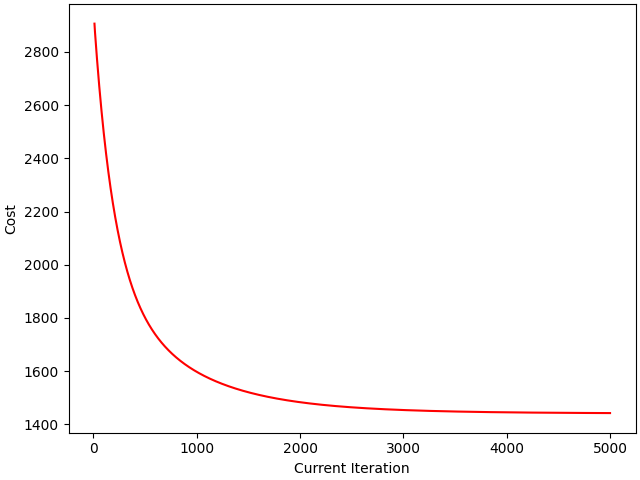

In [8]:
iteration = iteration[10:]
costs = costs[10:]

# graph the cost after updating the model
fig, cost_graph = plt.subplots(layout='constrained')

cost_graph.set_xlabel("Current Iteration")
cost_graph.set_ylabel("Cost")

cost_graph.plot(iteration, costs, color="r")

Cost Graph over Gradient Descent Iterations

In [9]:
print("w:", w.reshape((-1)))
print("b:", b)
print("1st Cost:", costs[0])
print("Nth Cost:", costs[-1])

w: [  -2.46599763 -225.01427119  515.18188625  315.32548313  -54.0633404
 -117.13314535 -208.24751658  122.23408093  438.87518952   97.14937745]
b: 152.133484162896
1st Cost: 2906.5011616297534
Nth Cost: 1442.1449690343827


Firstly, the cost is definitely better than simple linear regression. Cost for it was around ~2K but here it is around ~1.5K.
This shows that having multiple features is better than single feature only.

More importantly however, The weights are actually huge even with feature scaling enabled. 
This is most likely because the severity (output) values are also huge. 
This also explains why the gradients blew up. Because without the feature scaling, gradients become too big to store in float64 data type.

Time to use SGDRegressor to verify

In [10]:
sgd = SGDRegressor(max_iter=5000, penalty=None) # variable learning rate
reg = make_pipeline(StandardScaler(), sgd)
reg.fit(data, severity.reshape((-1)))
sgdout = reg.predict(data).reshape((-1,1))

sgderror = (sgdout - severity).reshape((-1)) # compute errors from sgd predictions and actual values
sgdcost = np.dot(sgderror, sgderror) / (2*m) # compute minimized final cost
print("SGD Cost:", sgdcost)

SGD Cost: 1439.1283642656851


Nice, the cost for SGD is very close to the custom gradient descent cost. 
Time to rank the features and see which features are more correlated to the output.
This is a good way to test the model validity.

In [11]:
feature_names = diabetes.feature_names
print(feature_names) # show feature names associated with input

w=w.reshape(-1)
w=np.abs(w)
wp = w / np.sum(w)
print(wp)

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
[0.0011767  0.10737    0.24582921 0.15046378 0.02579739 0.05589239
 0.09936941 0.05832641 0.20941796 0.04635674]


Text(0, 0.5, 'Importance')

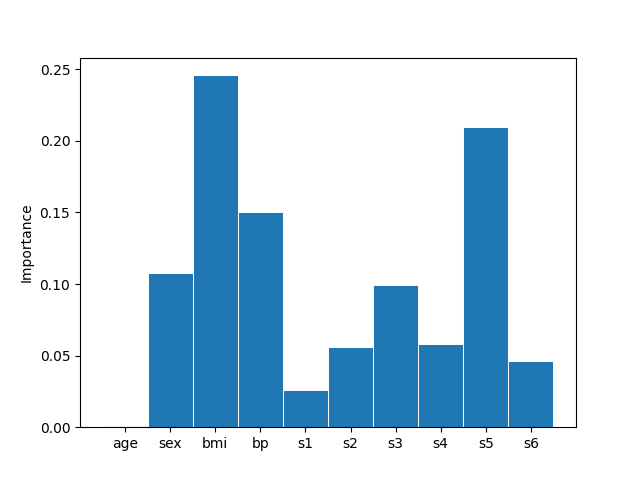

In [12]:
fig, ax = plt.subplots()
ax.bar(feature_names, wp, width=1, edgecolor="white", linewidth=0.7)
ax.set_ylabel("Importance")

From this, its clear that sex, bmi, bp and s5 are features that definitely influence the severity. 
It's also interesting that age doesn't really influence the severity. 
This makes sense because the visualization in simple linear regression also shows the same detail.
Could also use a correlation matrix heatmap to show bi-relationships between features.

Time to show pair plots, 3d scatter plots

A residual plot of the model. Another way to verify the model is valid

Text(0.5, 1.0, 'Residuals of Body Mass Index')

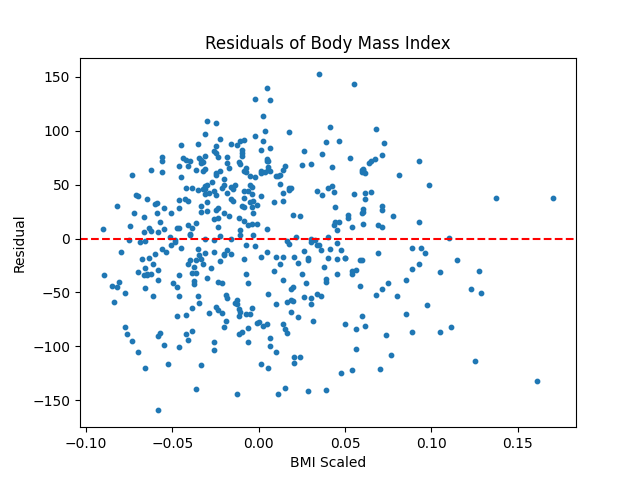

In [13]:
prediction = predict(w,b,data)
residuals = prediction - severity.reshape((-1))
bmi = data[:,2]

fig, ax = plt.subplots()
ax.scatter(bmi, residuals, s=10)
ax.axhline(y=0., color='r', linestyle='--')
ax.set_xlabel("BMI Scaled")
ax.set_ylabel("Residual")
ax.set_title("Residuals of Body Mass Index")

These residuals do look normally distributed and centered. 
This is another way to check a model's validity.

Let's look at some pair plots. 
I will choose sex, bmi, bp and s5 as they're highly correlated to the output.

In [14]:
diabetesU = load_diabetes(scaled=False) # disable Feature Scaling for visualization
dataU = diabetesU.data

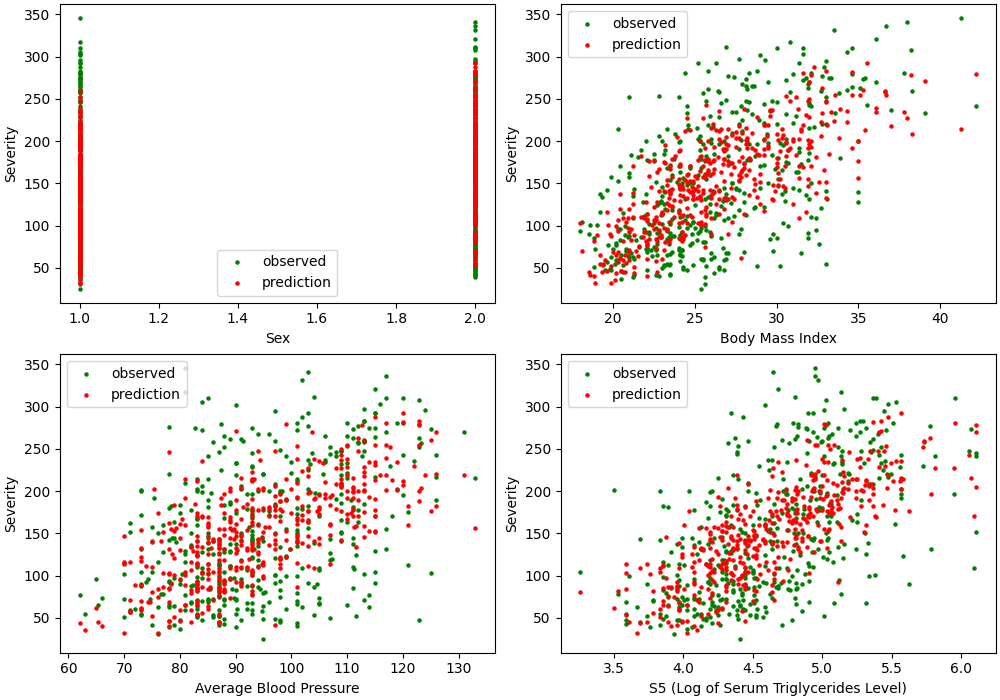

In [15]:
sex = dataU[:,1]
bmi = dataU[:,2]
bp = dataU[:,3]
s5 = dataU[:,8]

fig, axs = plt.subplots(2, 2, layout='constrained',figsize=(10,7))
psex, pbmi = axs[0, 0], axs[0, 1]
pbp, ps5 = axs[1, 0], axs[1, 1]

psex.set_xlabel("Sex")
pbmi.set_xlabel("Body Mass Index")
pbp.set_xlabel("Average Blood Pressure")
ps5.set_xlabel("S5 (Log of Serum Triglycerides Level)")

pbp.set_ylabel("Severity")
psex.set_ylabel("Severity")
pbmi.set_ylabel("Severity")
ps5.set_ylabel("Severity")

pbp.scatter(bp, severity, color="g",s=5, label="observed")
psex.scatter(sex, severity, color="g",s=5, label="observed")
pbmi.scatter(bmi, severity, color="g",s=5, label="observed")
ps5.scatter(s5, severity, color="g",s=5, label="observed")

pbp.scatter(bp, prediction, color="r",s=5, label="prediction")
psex.scatter(sex, prediction, color="r",s=5, label="prediction")
pbmi.scatter(bmi, prediction, color="r",s=5, label="prediction")
ps5.scatter(s5, prediction, color="r",s=5, label="prediction")

pbp.legend()
psex.legend()
pbmi.legend()
ps5.legend()

This is a good visual to show that the model predicts accurately to a majority of the dataset. 
However, it's still not perfect and there are a lot of observed values that the model couldn't reach.
This is presumably since the linear model isn't good enough. 
We need a more complex model like involving polynomials for example.
But still a decent model for sure.

Next, i will show a 3d scatter plot to see which features correlate to the output data more. We'll choose bmi,bp, and s5 to visualize.

Text(0.5, 0.92, 'Severity of diabetes')

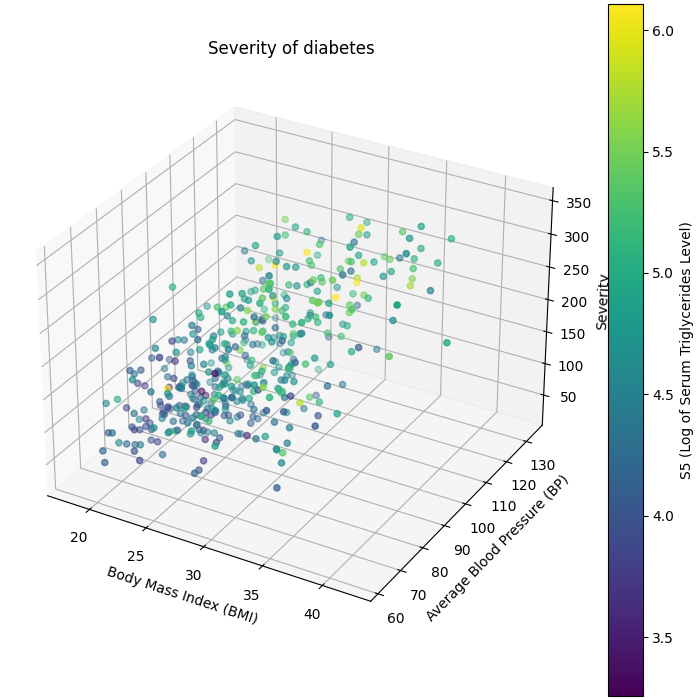

In [16]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(7,7), layout='constrained')
scatter = ax.scatter(bmi, bp, severity.reshape((-1)), c=s5, cmap='viridis')

cbar = fig.colorbar(scatter)
cbar.set_label('S5 (Log of Serum Triglycerides Level)')

# Set labels
ax.set_xlabel('Body Mass Index (BMI)')
ax.set_ylabel('Average Blood Pressure (BP)')
ax.set_zlabel('Severity')

ax.set_title('Severity of diabetes')

Using color as another dimension is very clever indeed. 
I got this idea from https://rstudio-pubs-static.s3.amazonaws.com/333161_63e85a8c0f5b446d9d197923bb067086.html

From this it's easy to see that higher BMI has a higher chance on having higher severity. They're have a positive correlation.
It's harder to see the same correlation with BP but it absolutely exists if you look hard enough. 
Another thing is that S5 is also highly correlated with severity. 
Lower S5 has a low severity on average and Higher S5 has higher severity as indicated by the colors.